# # Remaining Useful Life Prediction with Informer on PHM08 Dataset

In [16]:
# %% [markdown]
# ## 1. Setup and Imports
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torchinfo import summary
import pickle

In [17]:
# %% [markdown]
# Files expected: train.txt, test.txt, final_test.txt (if available)

In [18]:
# %% [markdown]
# ## 3. Load and Preprocess Data
def load_phm08(path, filename):
    cols = list(range(26))  # 26 columns
    df = pd.read_csv(os.path.join(path, filename), sep="\s+", header=None, names=cols)
    return df

train_df = load_phm08("data/Challenge_Data/", "train.txt")
test_df = load_phm08("data/Challenge_Data/", "test.txt")

# Extract RUL for training set
rul_per_unit = train_df.groupby(0)[1].max().reset_index()
rul_per_unit.columns = ["unit", "max_cycle"]
train_df = train_df.rename(columns={0: "unit", 1: "cycle"})
train_df = train_df.merge(rul_per_unit, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

# Extract RUL for training set
rul_per_unit_test = test_df.groupby(0)[1].max().reset_index()
rul_per_unit_test.columns = ["unit", "max_cycle"]
test_df = test_df.rename(columns={0: "unit", 1: "cycle"})
test_df = test_df.merge(rul_per_unit_test, on="unit", how="left")
test_df["RUL"] = test_df["max_cycle"] - test_df["cycle"]


In [19]:
train_df[train_df["unit"] == 2]

,unit,cycle,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,max_cycle,RUL
223,2,1,0.0017,0.0006,100.0,518.67,641.59,1578.61,1401.71,14.62,...,8135.46,8.4292,0.03,392,2388,100.00,39.00,23.4589,164,163
224,2,2,35.0026,0.8405,60.0,449.44,554.68,1357.66,1117.74,5.48,...,8066.59,9.2676,0.02,334,2223,100.00,14.69,8.9947,164,162
225,2,3,42.0011,0.8400,40.0,445.00,548.63,1347.31,1118.90,3.91,...,8088.80,9.3370,0.02,330,2212,100.00,10.70,6.3830,164,161
226,2,4,42.0003,0.8407,40.0,445.00,548.88,1350.73,1125.61,3.91,...,8086.30,9.3200,0.02,329,2212,100.00,10.43,6.3872,164,160
227,2,5,20.0023,0.7000,0.0,491.19,606.99,1477.32,1237.14,9.35,...,8056.67,9.1704,0.02,364,2324,100.00,24.62,14.8277,164,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2,160,0.0027,0.0000,100.0,518.67,643.58,1602.22,1431.34,14.62,...,8123.17,8.5251,0.03,394,2388,100.00,38.54,23.1603,164,4
383,2,161,42.0045,0.8418,40.0,445.00,550.82,1365.84,1144.76,3.91,...,8064.40,9.4743,0.02,334,2212,100.00,10.61,6.3184,164,3
384,2,162,0.0024,0.0000,100.0,518.67,643.87,1603.07,1429.17,14.62,...,8119.39,8.5228,0.03,395,2388,100.00,38.51,23.1345,164,2
385,2,163,35.0056,0.8417,60.0,449.44,556.59,1371.32,1153.13,5.48,...,8044.32,9.3913,0.02,337,2223,100.00,14.50,8.6654,164,1


In [20]:
# %% [markdown]
# ## 4. Sliding Window Dataset
class PHM08RULDataset(Dataset):
    def __init__(self, df, seq_len=30, unit_ids=None):
        """
        df       : preprocessed dataframe with ['unit','cycle','RUL', features...]
        seq_len  : sequence length for time series
        unit_ids : list of engine IDs to include (if None → use all units)
        """
        if unit_ids is not None:
            self.df = df[df["unit"].isin(unit_ids)].reset_index(drop=True)
        else:
            self.df = df.copy().reset_index(drop=True)

        self.seq_len = seq_len

        # Features = all numeric columns except meta/labels
        self.features = self.df.columns.difference(
            ["unit", "cycle", "max_cycle", "RUL"]
        ).tolist()

        # Build all (X,y) sequences
        self.samples = []
        grouped = self.df.groupby("unit")
        for _, group in grouped:
            group = group.sort_values("cycle")
            values = group[self.features].values
            rul_values = group["RUL"].values

            for i in range(len(group) - seq_len + 1):
                x_seq = values[i:i+seq_len]
                y_val = rul_values[i+seq_len-1]
                self.samples.append((x_seq, y_val))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_len = 100
units = train_df["unit"].unique()   # all engine IDs
print(f"Total engines: {len(units)}")

from sklearn.model_selection import train_test_split

# First split into train+val vs test
train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)

# Apply Feature scaling to transform the scaling of different features into similar scales.
feature_cols = train_df.columns.difference(["unit", "cycle", "max_cycle", "RUL"])
training_df = train_df[train_df["unit"].isin(train_units)].copy()
val_df   = train_df[train_df["unit"].isin(val_units)].copy()

scaler = StandardScaler()
training_df[feature_cols] = scaler.fit_transform(training_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])

from torch.utils.data import Subset

train_dataset = PHM08RULDataset(training_df, seq_len=seq_len, unit_ids=train_units)
val_dataset   = PHM08RULDataset(val_df, seq_len=seq_len, unit_ids=val_units)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)



Total engines: 218
Total test engines: 218


In [21]:
# %% [markdown]
# ----------------------
# RNN Encoder-Decoder
# ----------------------
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, L, D = x.shape
        H = self.n_heads

        Q = self.q_linear(x).view(B, L, H, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, L, H, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, L, H, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.fc_out(out)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=256, dropout=0.1):
        super().__init__()
        self.attn = ProbSparseSelfAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out = self.attn(x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


class InformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, n_heads):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class InformerRUL(nn.Module):
    def __init__(self, num_features, d_model=128, n_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.encoder = InformerEncoder(num_layers, d_model, n_heads)
        self.regressor = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)         # [B, L, d_model]
        x = self.encoder(x)            # [B, L, d_model]
        x = x.transpose(1, 2)          # [B, d_model, L]
        out = self.regressor(x)        # [B, 1]
        return out.squeeze(-1)

In [22]:
# ----------------------
# RNN Encoder-Decoder
# ----------------------
class RNNRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=56, num_layers=2, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim1, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out, _ = self.rnn(x)           # [B, L, H]
        out = out[:, -1, :]            # take last timestep
        out = self.bn(out)             # batch norm
        out = self.dropout1(out)       # first dropout

        out, _ = self.rnn2(out.unsqueeze(1))  # add 2nd RNN
        out = out[:, -1, :]

        out = self.dropout2(out)
        out = self.fc(out)
        return self.relu(out).squeeze(-1)

# ----------------------
# LSTM Encoder-Decoder
# ----------------------
class LSTMRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=56, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.dropout1(out)

        out, _ = self.lstm2(out.unsqueeze(1))
        out = out[:, -1, :]

        out = self.dropout2(out)
        out = self.fc(out)
        return self.relu(out).squeeze(-1)
# ----------------------
# Seq2Seq Wrapper
# ----------------------
class Seq2SeqRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=56, num_layers=2, dropout=0.3):
        super().__init__()
        # Encoder
        self.encoder1 = nn.LSTM(input_dim, hidden_dim1, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)

        # Second Encoder-like block
        self.encoder2 = nn.LSTM(hidden_dim1, hidden_dim2, num_layers, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim2, 1)


    def forward(self, x):
        enc_out, _ = self.encoder1(x)
        out = enc_out[:, -1, :]        # last timestep
        out = self.bn(out)
        out = self.dropout1(out)

        out, _ = self.encoder2(out.unsqueeze(1))
        out = out[:, -1, :]

        out = self.dropout2(out)
        out = self.fc(out)
        return self.relu(out).squeeze(-1)

In [55]:
# %% [markdown]
# ## 6. Training Function
import time

def train_model(model, train_loader, val_loader, opt="adam", device="cpu", epochs=20, lr=1e-3):
    model.to(device)
    criterion = nn.MSELoss()
    if opt == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "rms":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs+1):
        train_preds = []
        train_true_rul = []
        val_preds = []
        val_true_rul = []

        start = time.time()
        model.train()
        total_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader, 1):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            train_preds.extend(pred.cpu().detach().numpy().ravel())
            train_true_rul.extend(y.cpu().detach().numpy().ravel())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # # Print every 50 batches
            # if batch_idx % 50 == 0 or batch_idx == len(train_loader):
            #     print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_preds.extend(pred.cpu().numpy().ravel())
                val_true_rul.extend(y.cpu().numpy().ravel())
                val_loss += criterion(pred, y).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        end = time.time()
        total_time = end-start
        print(f"Epoch {epoch} Completed — Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f} | Time Elapsed: {total_time:.2f} seconds")
    print("-"*60)

    return train_preds, train_true_rul, val_preds, val_true_rul, train_losses, val_losses

In [56]:
# Model selection
# Select models from RNN, LSTM, Informer ["RNN", "LSTM", "Seq2Seq", "Informer"]
num_features=len(train_dataset.features)

models = {
    "RNN": RNNRUL(num_features),
    "LSTM": LSTMRUL(num_features),
    "Seq2Seq": Seq2SeqRUL(num_features),
    "Informer": InformerRUL(num_features=len(train_dataset.features), d_model=128, n_heads=4, num_layers=2)   
}



In [57]:
from itertools import product

def grid_search(model_class, param_grid, train_dataset, val_dataset, device="cuda"):
    results = []
    best_model = None
    best_loss = float("inf")

    # Build train/val loaders
    for params in product(*param_grid.values()):
        hp = dict(zip(param_grid.keys(), params))

        # Sequencing
        seq_len = hp.get("seq_len",10)
        train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)
        
        # Apply Feature scaling to transform the scaling of different features into similar scales.
        feature_cols = train_df.columns.difference(["unit", "cycle", "max_cycle", "RUL"])
        training_df = train_df[train_df["unit"].isin(train_units)].copy()
        val_df   = train_df[train_df["unit"].isin(val_units)].copy()
        
        scaler = StandardScaler()
        training_df[feature_cols] = scaler.fit_transform(training_df[feature_cols])
        val_df[feature_cols]   = scaler.transform(val_df[feature_cols])

        train_dataset = PHM08RULDataset(training_df, seq_len=seq_len, unit_ids=train_units)
        val_dataset   = PHM08RULDataset(val_df, seq_len=seq_len, unit_ids=val_units)

        # Dataloaders
        train_loader = DataLoader(train_dataset, batch_size=hp.get("batch_size",64), shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=hp.get("batch_size",64))

        # Model
        if model_class == "InformerRUL":
            model = model_class(
                num_features=len(train_dataset.features),
                d_model=hp.get("d_model", 128),
                n_heads=hp.get("n_heads", 4),
                num_layers=hp.get("num_layers", 2)
            )
        else:
            model = model_class(
                input_dim=len(train_dataset.features),
                hidden_dim1=hp.get("hidden_dim1", 128),
                hidden_dim2=hp.get("hidden_dim2", 128),
                num_layers=hp.get("num_layers", 128),
                dropout=hp.get("dropout", 128)
            )

        print(f"\n🔎 Training with model {model.__class__.__name__} params: {hp}")
        train_preds, train_true_rul, val_preds, val_true_rul, avg_train_loss, avg_val_loss = train_model(
            model, train_loader, val_loader,
            epochs=hp.get("epochs", 20),
            lr=hp.get("lr", 1e-3),
            opt=hp.get("opt", "adam"),
            device=device
        )

        results.append((hp, avg_val_loss))

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model = model
            best_params = hp

    print("\n✅ Grid Search Complete")
    print(f"Best Params: {results[min(range(len(results)), key=lambda i: results[i][1])][0]}")
    print(f"Best Val Loss: {best_loss:.4f}")

    return best_model, best_params, best_loss, results


In [58]:
# model_results = {}
# model_names = ["Seq2Seq"]   # <-- change to "Informer", "RNN", "LSTM", or "Seq2Seq"
# # model_names = ["LSTM"]   # <-- change to "Informer", "RNN", "LSTM", or "Seq2Seq"
# device="cuda" if torch.cuda.is_available() else "cpu"

# for model_name in model_names:
#     model = models[model_name].to(device)
#     if model_name == "Informer":
#         param_grid = {
#         "seq_len": [5],
#         "batch_size": [32, 64],
#         "lr": [1e-3],
#         "d_model": [64],
#         "n_heads": [2],
#         "num_layers": [1],
#         "epochs": [2]  # keep small for test
#         }
#     else:
#         param_grid = {
#         "opt": ["rms", "adam"], 
#         "hidden_dim1": [128, 256],
#         "hidden_dim2": [56, 112],
#         "num_layers": [1, 2],
#         "dropout": [0.1, 0.2],
#         "seq_len": [25, 50, 100],
#         "batch_size": [32, 64],
#         "lr": [1e-3, 5e-3, 1e-2],
#         "epochs": [10]  # keep small for test
#         }
#     best_model, best_params, best_loss, results = grid_search(
#         model.__class__, param_grid,
#         train_dataset, val_dataset,
#         device="cuda" if torch.cuda.is_available() else "cpu"
#     )
#     model_results[model.__class__.__name__] =  {
#                                                     "Best Model": best_model,
#                                                     "Best Params": best_params,
#                                                     "Best Loss": best_loss,
#                                                     "results": results
#                                                 }


In [59]:
# summary = []

# for model_name, info in model_results.items():
#     # pick best (lowest val_loss) from results
#     best_params, best_loss = min(info["results"], key=lambda x: x[1])
#     summary.append({
#         "Model": model_name,
#         "Best Params": best_params,
#         "Best Val Loss": best_loss
#     })

# df_summary = pd.DataFrame(summary)
# df_summary

In [60]:
# model_results

In [61]:
# %% [markdown]
# ## 7. Run Training

num_features=len(train_dataset.features)
params = {
        "input_dim": num_features,
        "hidden_dim1": 128,
        "hidden_dim2": 64,
        "num_layers": 1,
        "dropout": 0.2,
        }

models = {
    "RNN": RNNRUL(**params),
    "LSTM": LSTMRUL(**params),
    "Seq2Seq": Seq2SeqRUL(**params),
}

lr = 1e-3
epochs = 20
model_name = "Seq2Seq"   # <-- change to "Informer", "RNN", "LSTM", or "Seq2Seq"
# model_names = ["LSTM"]   # <-- change to "Informer", "RNN", "LSTM", or "Seq2Seq"
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

model = models[model_name]

print("Starting training...")
train_preds, train_true_rul, val_preds, val_true_rul, train_loss, val_loss = train_model(
            model, train_loader, val_loader,
            epochs=epochs,
            lr=lr,
            opt="rms",
            device=device
        )
print("Training completed.")

Using device: cuda
Starting training...
Epoch 1 Completed — Avg Train Loss: 3914.6328 | Avg Val Loss: 3166.3290 | Time Elapsed: 2.02 seconds
Epoch 2 Completed — Avg Train Loss: 1963.9292 | Avg Val Loss: 1464.3985 | Time Elapsed: 2.01 seconds
Epoch 3 Completed — Avg Train Loss: 1101.6945 | Avg Val Loss: 1084.7116 | Time Elapsed: 2.00 seconds
Epoch 4 Completed — Avg Train Loss: 782.2178 | Avg Val Loss: 587.5640 | Time Elapsed: 1.99 seconds
Epoch 5 Completed — Avg Train Loss: 617.2681 | Avg Val Loss: 641.7354 | Time Elapsed: 1.99 seconds
Epoch 6 Completed — Avg Train Loss: 500.7906 | Avg Val Loss: 520.4960 | Time Elapsed: 1.99 seconds
Epoch 7 Completed — Avg Train Loss: 422.9824 | Avg Val Loss: 622.4610 | Time Elapsed: 2.01 seconds
Epoch 8 Completed — Avg Train Loss: 355.1468 | Avg Val Loss: 637.5329 | Time Elapsed: 1.99 seconds
Epoch 9 Completed — Avg Train Loss: 296.4820 | Avg Val Loss: 578.8531 | Time Elapsed: 2.00 seconds
Epoch 10 Completed — Avg Train Loss: 251.2256 | Avg Val Loss: 6

In [62]:
# Save parameters
torch.save(model.state_dict(), "model/model.pth")

In [63]:
summary(model, input_size=(32, 100, len(train_dataset.features)))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2SeqRUL                               [32]                      --
├─LSTM: 1-1                              [32, 100, 128]            78,848
├─BatchNorm1d: 1-2                       [32, 128]                 256
├─Dropout: 1-3                           [32, 128]                 --
├─LSTM: 1-4                              [32, 1, 64]               49,664
├─Dropout: 1-5                           [32, 64]                  --
├─Linear: 1-6                            [32, 1]                   65
├─ReLU: 1-7                              [32, 1]                   --
Total params: 128,833
Trainable params: 128,833
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 253.91
Input size (MB): 0.31
Forward/backward pass size (MB): 3.33
Params size (MB): 0.52
Estimated Total Size (MB): 4.15

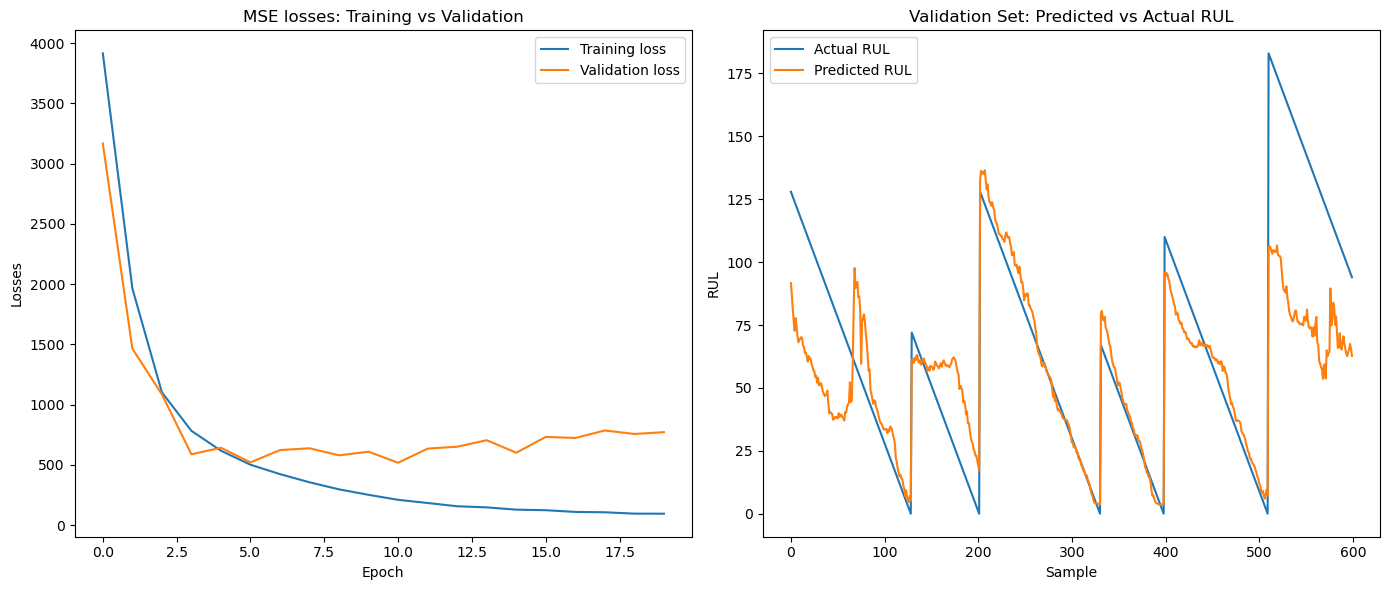

In [66]:
plt.figure(figsize=(14,6))
train_preds, train_true_rul, val_preds, val_true_rul, train_loss, val_loss
# Training
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.title("MSE losses: Training vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend()

# Validation
plt.subplot(1,2,2)
plt.plot(val_true_rul[:600], label="Actual RUL")
plt.plot(val_preds[:600], label="Predicted RUL")
plt.title("Validation Set: Predicted vs Actual RUL")
plt.xlabel("Sample")
plt.ylabel("RUL")
plt.legend()

plt.tight_layout()
plt.show()

Total test engines: 218
Test Set Evaluation:
MSE: 576841.4986


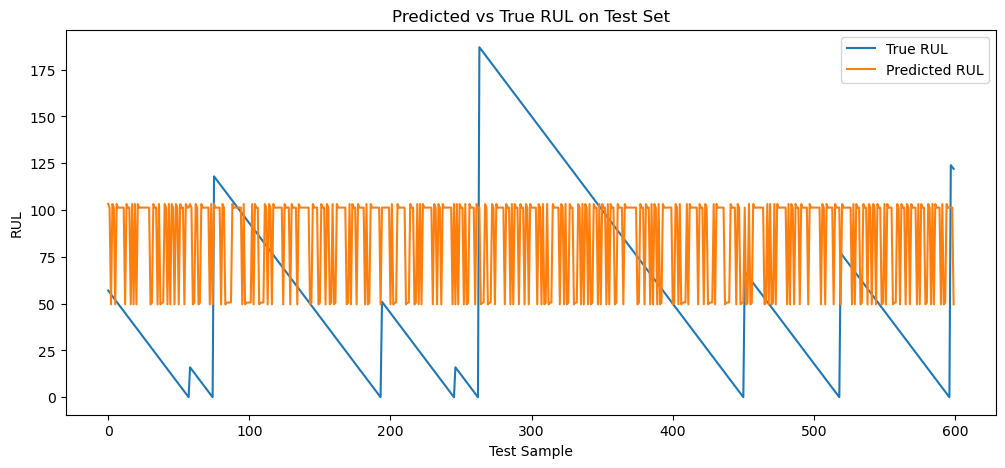

In [72]:
# %% [markdown]
# ## 8. Evaluation on Test Set (if RUL available) or inference
# Preprocess test_df for inference
# test_dataset = PHM08RULDataset(test_df, seq_len=seq_len)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#test
test_units = test_df["unit"].unique()   # all engine IDs
print(f"Total test engines: {len(units)}")
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])
test_dataset  = PHM08RULDataset(test_df, seq_len=seq_len, unit_ids=test_units)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
preds = []
true_rul = []
test_loss = 0
# with torch.no_grad():
#     for x_test, y_test in test_loader:
#         x_test = x_test.to(device)
#         output = model(x_test)
#         preds.extend(output.cpu().numpy())
#         true_rul.extend(y_test.numpy())

model.to(device)
criterion = nn.MSELoss()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        output = model(x_test)
        preds.extend(output.cpu().numpy().ravel())
        true_rul.extend(y_test.cpu().numpy().ravel())
        test_loss += criterion(output, y_test).item()

# Convert to numpy arrays
preds = np.array(preds)
true_rul = np.array(true_rul)

# Print basic metrics
rmse = np.sqrt(np.mean((preds - true_rul)**2))
mae = np.mean(np.abs(preds - true_rul))

print("="*60)
print(f"Test Set Evaluation:")
print(f"MSE: {test_loss:.4f}")
print("="*60)

# Optional: visualize predicted vs true RUL
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(true_rul[:600], label="True RUL")
plt.plot(preds[:600], label="Predicted RUL")
plt.xlabel("Test Sample")
plt.ylabel("RUL")
plt.title("Predicted vs True RUL on Test Set")
plt.legend()
plt.show()
